In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py 
from dedalus import public as de
from dedalus.extras import flow_tools
import time
from IPython import display
from matplotlib import animation
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal

In [3]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

## Dominio del problema

##### Cambios hechos
- El perfil de temperaturas va a ser constante, es decir se va a manter en `T0 = 20` en todo el dominio.
- Se cambia la ecuación de estado del agua por $$\rho = \rho_0 - \alpha(T-T_0) + \beta(S - S_0)$$
- 
    - Expansión térmica: $\alpha = 0.15 kg/(m^3 ºC)$
    - Salinity contraction: $\beta = 0.78 kg/(m^3 \ 1/1000)$
    

In [4]:
Lx, Ly = (0.2, 0.35)
nx, ny = (256, 256)
#Prandtl = 1.
#Rayleigh = 5.8e7

ν = 1.8e-6 # m^2/s viscocidad cinemática
k = 2e-5 # s^-1 
T0 = 20.0 # ºC Promedio de las temperaturas iniciales
T_b = 22.0 #Bottom temperature ºC
g = 9.8 #  m/s^2
κ = 1.3e-7 #thermal difussivity m^2/s
ρ0 = 1007.5 # kg/m^3 promedio de las densidades iniciales
α = 0.15 # kg/m^3ºC thermal expansion
β = 0.78 # kg/m^3%0 salinity contraction
s_top = 13.54 # 0. #salinidad top (partes por mil)
s_bot = 13.54 #salinidad bottom (partes por mil)
s0 = 13.54 #9.375

T_air = 18. # ºC temperatura de aire.
T_top = 20.0
z_int = 0.18
L_conv = 0.35
Reynolds = 100
Schmidt = 1

x_basis = de.Fourier('x', nx, interval=(0, Lx))
y_basis = de.Chebyshev('y', ny, interval=(0, Ly))
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

## Ecuaciones

In [5]:
problem = de.IVP(domain, variables=['p', 'u', 'v', 'ρ', 's', 'T', 'uy', 'vy', 'Ty', 'sy'])

In [6]:
problem.meta['p', 'T', 'u', 'v', 'ρ', 's']['y']['dirichlet'] = True

In [7]:
#problem.parameters['P'] = (Rayleigh * Prandtl)**(-1/2)
#problem.parameters['R'] = (Rayleigh / Prandtl)**(-1/2)
#problem.parameters['F'] = F = 1
problem.parameters['ν'] = ν
problem.parameters['κ'] = κ
problem.parameters['T_air'] = T_air
problem.parameters['k'] = k 
problem.parameters['ρ0'] = ρ0
problem.parameters['T_0'] = T0 #4.0 ºC
problem.parameters['g'] = 9.8
problem.parameters['α'] = α
problem.parameters['β'] = β
problem.parameters['T_b'] = T_b
problem.parameters['T_top'] = T_top
problem.parameters['s0'] = s0
problem.parameters['s_top'] = s_top
problem.parameters['s_bot'] = s_bot

problem.parameters['Re'] = Reynolds
problem.parameters['Sc'] = Schmidt

problem.add_equation("dx(u) + vy = 0") #continuidad
problem.add_equation("dt(u) - ν*(dx(dx(u)) + dy(uy)) + dx(p) = -(u*dx(u) + v*uy)") #N-S x
problem.add_equation("dt(v) - ν*(dx(dx(v)) + dy(vy)) + dy(p) = -(u*dx(v) + v*vy) + g*(ρ - ρ0)/ρ0") #N-S y
problem.add_equation("dt(T) - κ*(dx(dx(T)) + dy(Ty)) = - u*dx(T) - v*Ty - k*(T - T_air)") #conservación energía
problem.add_equation("ρ = ρ0 - α*(T - T_0) + β*(s - s0)") #ecuación de estado
problem.add_equation("dt(s) - 1/(Re*Sc)*(dx(dx(s)) + dy(sy)) = - u*dx(s) - v*sy") #ecuación para salinidad

problem.add_equation("Ty - dy(T) = 0")
problem.add_equation("uy - dy(u) = 0")
problem.add_equation("vy - dy(v) = 0")
problem.add_equation("sy - dy(s) = 0")

problem.add_bc("left(T) = T_b")
problem.add_bc("right(T) = T_top")
problem.add_bc("left(u) = 0")
problem.add_bc("left(v) = 0")
problem.add_bc("left(s) = s_bot")
problem.add_bc("right(v) = s_top")
problem.add_bc("right(u) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("right(p) = 0", condition="(nx == 0)")

## Condiciones de frontera

In [8]:
solver = problem.build_solver(de.timesteppers.RK222)

2017-09-03 13:56:46,865 pencil 0/1 INFO :: Building pencil matrix 1/128 (~1%) Elapsed: 0s, Remaining: 8s, Rate: 1.6e+01/s
2017-09-03 13:56:47,513 pencil 0/1 INFO :: Building pencil matrix 13/128 (~10%) Elapsed: 1s, Remaining: 6s, Rate: 1.8e+01/s
2017-09-03 13:56:48,264 pencil 0/1 INFO :: Building pencil matrix 26/128 (~20%) Elapsed: 1s, Remaining: 6s, Rate: 1.8e+01/s
2017-09-03 13:56:49,020 pencil 0/1 INFO :: Building pencil matrix 39/128 (~30%) Elapsed: 2s, Remaining: 5s, Rate: 1.8e+01/s
2017-09-03 13:56:49,797 pencil 0/1 INFO :: Building pencil matrix 52/128 (~41%) Elapsed: 3s, Remaining: 4s, Rate: 1.7e+01/s
2017-09-03 13:56:50,534 pencil 0/1 INFO :: Building pencil matrix 65/128 (~51%) Elapsed: 4s, Remaining: 4s, Rate: 1.7e+01/s
2017-09-03 13:56:51,295 pencil 0/1 INFO :: Building pencil matrix 78/128 (~61%) Elapsed: 4s, Remaining: 3s, Rate: 1.7e+01/s
2017-09-03 13:56:52,041 pencil 0/1 INFO :: Building pencil matrix 91/128 (~71%) Elapsed: 5s, Remaining: 2s, Rate: 1.7e+01/s
2017-09-03

## Condiciones iniciales

In [9]:
x = domain.grid(0)
y = domain.grid(1)
T = solver.state['T']
Ty = solver.state['Ty']
ρ = solver.state['ρ']
s = solver.state['s']

#### Perfil de temepratura lineal

In [10]:
yb, yt = y_basis.interval

In [11]:
yt

0.35

In [12]:
x = domain.grid(0,scales=domain.dealias)
y = domain.grid(1,scales=domain.dealias)
xm, ym = np.meshgrid(x,y)

In [13]:
y.shape

(1, 256)

In [14]:
T['g'].shape

(256, 256)

In [15]:
T['g'] = np.zeros_like(y) + 20.

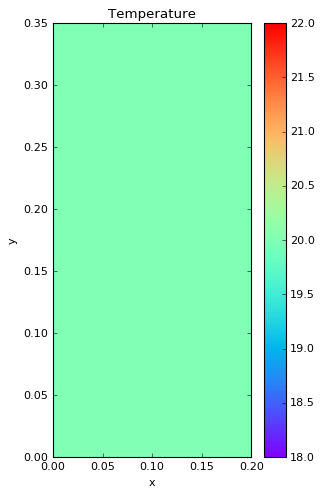

In [16]:
fig, axis = plt.subplots(figsize=(4,7))
pT = axis.pcolormesh(xm, ym, T['g'].T, cmap='rainbow');
plt.colorbar(pT)
plt.title('Temperature')
plt.xlabel('x')
plt.ylabel('y')

In [17]:
y.shape

(1, 256)

In [18]:
ρ['g'].shape

(256, 256)

In [19]:
#ρ['g'] = 1010.009 + -0.009 * np.exp(20 * y)
ρ['g'] = ρ0

In [20]:
len(np.zeros(256))

256

In [21]:
#ρ['g'] = np.zeros_like(ρ['g'])

In [22]:
#ρ['g'] = -58.82352941176471 * (y - 0.18) + 1010

In [23]:
#for i in range(0, 256):
 #   if y[0][i] < 0.18:
 #       ρ['g'][:, i] = np.zeros(256) + 1010. + np.random.rand(256)*0.1
        

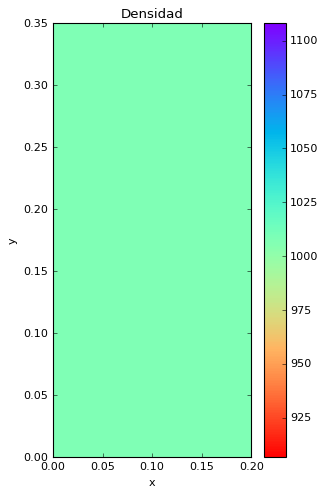

In [24]:
fig, axis = plt.subplots(figsize=(4,7))
pT = axis.pcolormesh(xm, ym, ρ['g'].T,  cmap='rainbow_r');
plt.colorbar(pT)
plt.title('Densidad')
plt.xlabel('x')
plt.ylabel('y')

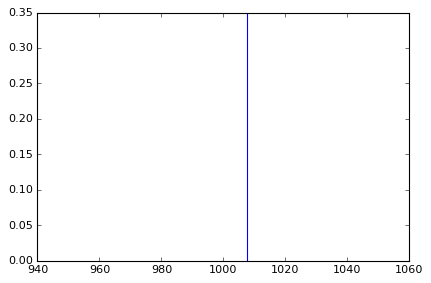

In [25]:
plt.plot(ρ['g'][5,:], y[0])

In [26]:
s['g'] = (ρ['g'] - ρ0 + α * (T['g'] - T0))/ β +  s0

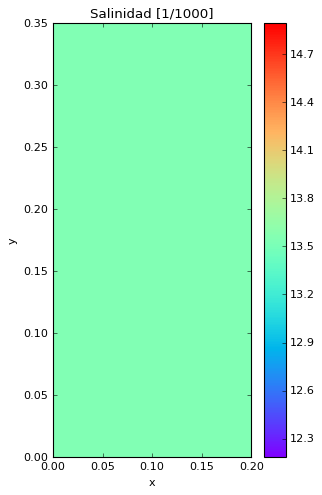

In [27]:
fig, axis = plt.subplots(figsize=(4,7))
pT = axis.pcolormesh(xm, ym, s['g'].T, cmap='rainbow');
plt.colorbar(pT)
plt.title('Salinidad [1/1000]')
plt.xlabel('x')
plt.ylabel('y')

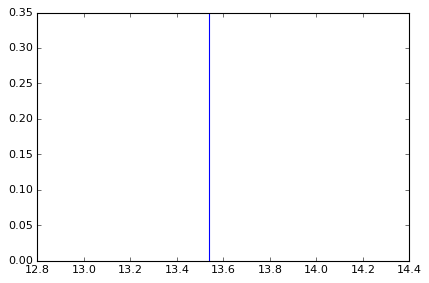

In [28]:
plt.plot(s['g'][5,:], y[0])

In [29]:
# Initial timestep
dt = 0.1
# Integration parameters
solver.stop_sim_time = 10
solver.stop_wall_time = 30 * 90.
solver.stop_iteration = np.inf

# Analysis
snapshots = solver.evaluator.add_file_handler('strat_andrea', sim_dt=0.25, max_writes=100)
snapshots.add_system(solver.state)

# CFL
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=5, safety=0.1, max_change=1.5, min_change=0.5, max_dt=0.02, threshold=0.01)
CFL.add_velocities(('u', 'v'))


In [30]:
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.ok:
        #print("hola")
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        if (solver.iteration-1) % 10 == 0:
            # Update plot of scalar field
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
            #logger.info('Max Re = %f' %flow.max('Re'))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f sec' %(end_time-start_time))
    logger.info('Run time: %f cpu-hr' %((end_time-start_time)/60/60*domain.dist.comm_cart.size))

2017-09-03 13:57:27,226 __main__ 0/1 INFO :: Starting loop


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:155: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


2017-09-03 13:57:28,684 __main__ 0/1 INFO :: Iteration: 1, Time: 1.000000e-01, dt: 1.000000e-01
2017-09-03 13:57:39,156 __main__ 0/1 INFO :: Iteration: 11, Time: 6.000000e-01, dt: 5.000000e-02
2017-09-03 13:57:49,617 __main__ 0/1 INFO :: Iteration: 21, Time: 1.100000e+00, dt: 5.000000e-02
2017-09-03 13:58:00,032 __main__ 0/1 INFO :: Iteration: 31, Time: 1.600000e+00, dt: 5.000000e-02
2017-09-03 13:58:10,353 __main__ 0/1 INFO :: Iteration: 41, Time: 2.100000e+00, dt: 5.000000e-02
2017-09-03 13:58:20,764 __main__ 0/1 INFO :: Iteration: 51, Time: 2.600000e+00, dt: 5.000000e-02
2017-09-03 13:58:31,251 __main__ 0/1 INFO :: Iteration: 61, Time: 3.100000e+00, dt: 5.000000e-02
2017-09-03 13:58:41,969 __main__ 0/1 INFO :: Iteration: 71, Time: 3.600000e+00, dt: 5.000000e-02
2017-09-03 13:58:52,759 __main__ 0/1 INFO :: Iteration: 81, Time: 4.100000e+00, dt: 5.000000e-02
2017-09-03 13:59:03,233 __main__ 0/1 INFO :: Iteration: 91, Time: 4.600000e+00, dt: 5.000000e-02
2017-09-03 13:59:13,849 __main_

# Análisis de datos

In [44]:
def extraer_datos(nombre_h5):

    with h5py.File(nombre_h5, flag ='r') as hdf:
        base_items = list(hdf.items())
        print(base_items, '\n')
        tasks = hdf.get('tasks')
        tasks_items = list(tasks.items())
        print(tasks_items)

        T = np.array(tasks.get('T'))
        print(T.shape)

        ρ = np.array(tasks.get('ρ'))
        print(ρ.shape)
        
        s = np.array(tasks.get('s'))
        print(s.shape)
        
    return T, ρ, s

In [45]:
T_dat , ρ_dat, s_dat = extraer_datos('strat_andrea/strat_andrea_s1/strat_andrea_s1_p0.h5')

[('scales', <HDF5 group "/scales" (10 members)>), ('tasks', <HDF5 group "/tasks" (10 members)>)] 

[('vy', <HDF5 dataset "vy": shape (40, 256, 256), type "<f8">), ('p', <HDF5 dataset "p": shape (40, 256, 256), type "<f8">), ('uy', <HDF5 dataset "uy": shape (40, 256, 256), type "<f8">), ('T', <HDF5 dataset "T": shape (40, 256, 256), type "<f8">), ('ρ', <HDF5 dataset "ρ": shape (40, 256, 256), type "<f8">), ('u', <HDF5 dataset "u": shape (40, 256, 256), type "<f8">), ('s', <HDF5 dataset "s": shape (40, 256, 256), type "<f8">), ('sy', <HDF5 dataset "sy": shape (40, 256, 256), type "<f8">), ('v', <HDF5 dataset "v": shape (40, 256, 256), type "<f8">), ('Ty', <HDF5 dataset "Ty": shape (40, 256, 256), type "<f8">)]
(40, 256, 256)
(40, 256, 256)
(40, 256, 256)


In [46]:
s_dat.shape

(40, 256, 256)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


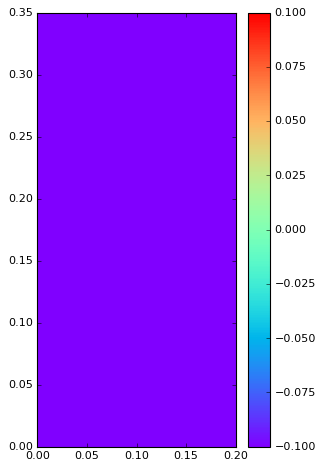

In [49]:
fig, axis = plt.subplots(figsize=(4,7))
p = axis.pcolormesh(xm, ym, ρ_dat[1].T, cmap='rainbow');
plt.colorbar(p)

In [52]:
ρ_dat[1].T

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])